# CRISIS 24

In [13]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [14]:
df = pd.read_csv("CRISIS24.csv").convert_dtypes()

# Rows and columns

In [15]:
rows, columns = df.shape
print(f"Rows: {rows}, Columns: {columns}")

Rows: 58725, Columns: 6


In [16]:
df['date'] = pd.to_datetime(df['yearmon'], errors='coerce').dt.date
df = df.convert_dtypes()
df = df.set_index(['date']).sort_index()
df = df.drop(columns=['yearmon'])

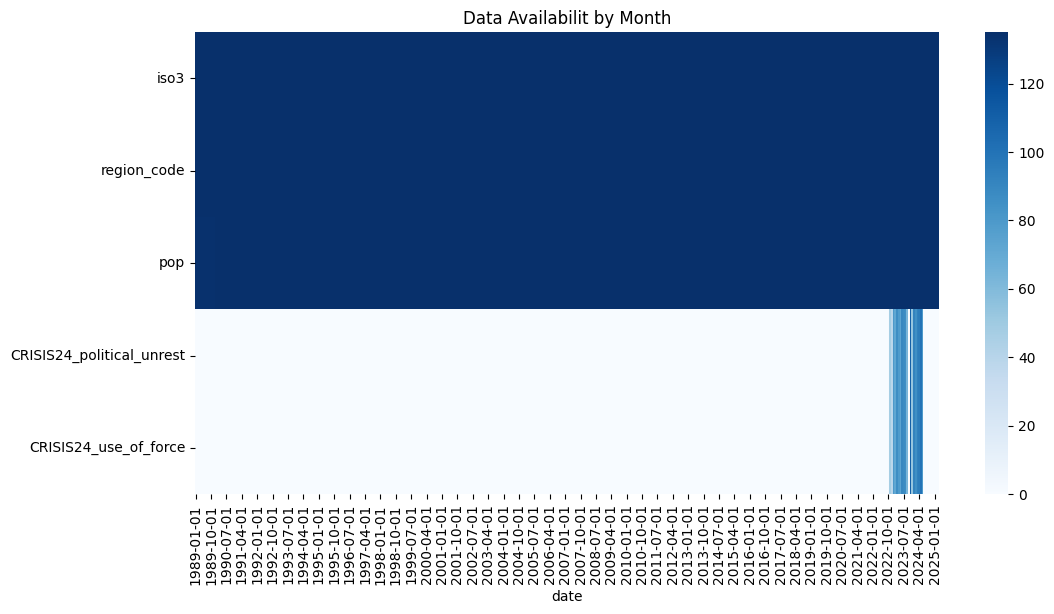

In [17]:
missing_by_month = df.groupby('date').count()
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_month.astype(float).T, cmap='Blues')
plt.title('Data Availabilit by Month')
plt.show()

### Sample data features

In [18]:
df.tail().T

date,2025-03-01,2025-03-01,2025-03-01,2025-03-01,2025-03-01
iso3,BLZ,TUV,ZMB,TUN,ZWE
region_code,LAC,EAP,SSA,MNA,SSA
pop,411106.0,9816.0,20723965.0,12200431.0,16340822.0
CRISIS24_political_unrest,<NA>,<NA>,<NA>,<NA>,<NA>
CRISIS24_use_of_force,<NA>,<NA>,<NA>,<NA>,<NA>


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58725 entries, 1989-01-01 to 2025-03-01
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   iso3                       58725 non-null  string 
 1   region_code                58725 non-null  string 
 2   pop                        58713 non-null  Float64
 3   CRISIS24_political_unrest  1513 non-null   Int64  
 4   CRISIS24_use_of_force      1513 non-null   Int64  
dtypes: Float64(1), Int64(2), string(2)
memory usage: 2.9+ MB


### Details of missing values 

In [20]:
# Step 1: Create missing summary
total_rows = len(df)
missing_count = df.isnull().sum()
missing_percent = (missing_count / total_rows * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percent
}).sort_values(by='Missing Percentage (%)', ascending=False)

# Step 2: Drop columns with >70% overall missing AND >20% missing in last 5 years of the data
for col in missing_df.index:
    if missing_percent[col] > 70:
        if 'date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['date']):
            max_date = df['date'].max()
            five_years_ago = max_date - pd.DateOffset(years=5)
            recent_df = df[df['date'] >= five_years_ago]
            recent_missing = recent_df[col].isnull().sum()
            recent_total = recent_df[col].shape[0]
            if recent_total == 0 or (recent_missing / recent_total * 100) > 20:
                df = df.drop(columns=[col])
        else:
            df = df.drop(columns=[col])  # Drop if no date context

# Step 3: Extract clean numeric data
numeric_df = df.select_dtypes(include=['number'])
numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan)
numeric_df = numeric_df.dropna(axis=1, how='all')  # Drop all-NaN columns
numeric_df = numeric_df.dropna(axis=0, how='any')  # Drop rows with any NaN




In [21]:
columns = missing_df[missing_df['Missing Percentage (%)'] < 70].index
df = df[columns]

numeric_df = df.select_dtypes(include=['number']).dropna()


In [22]:
#Correlation Matrix
correlation_matrix_df = numeric_df.corr(method='pearson')

## Correlation Matrix

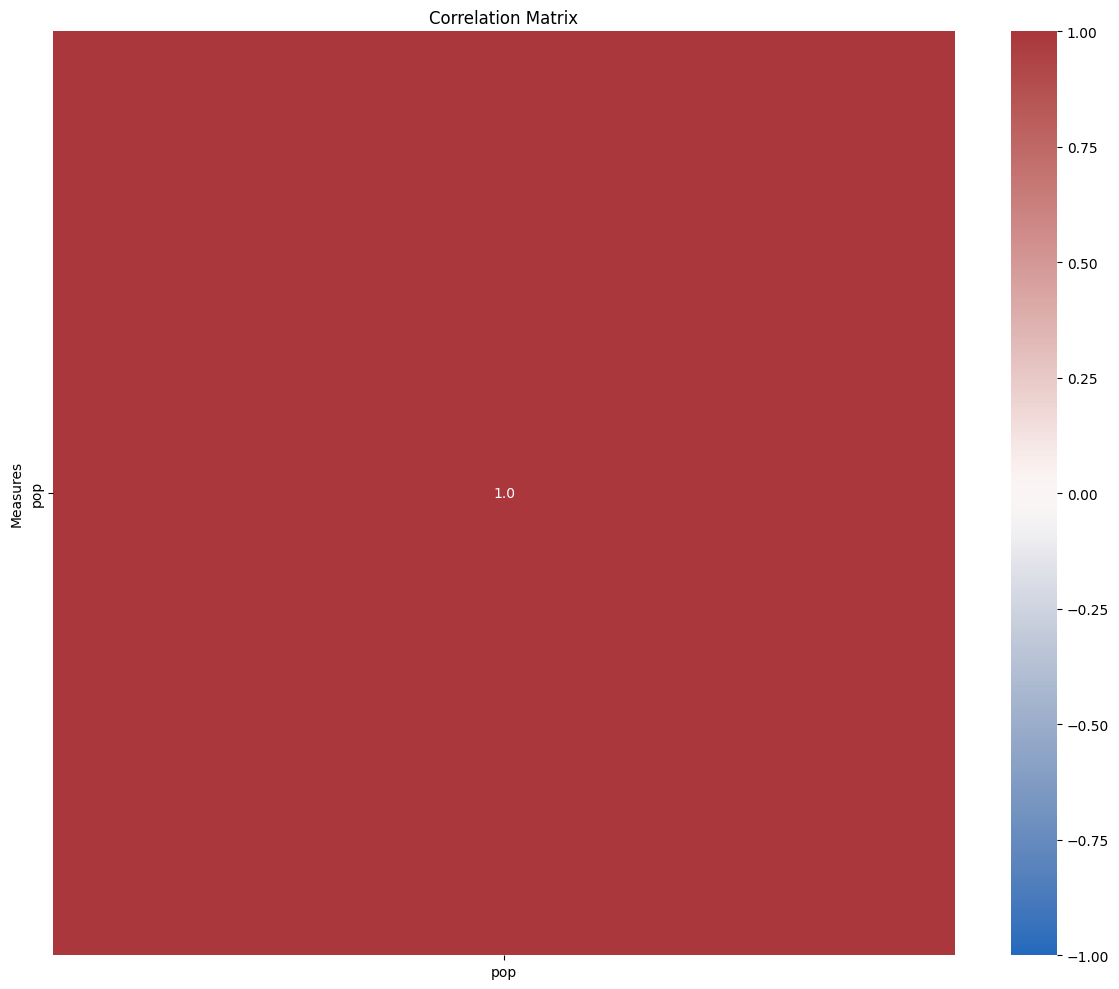

In [23]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_df, cmap='vlag', vmin=-1, vmax=1, annot=True, fmt=".1f")
plt.title('Correlation Matrix')
plt.ylabel('Measures')
plt.tight_layout()
plt.show()


### Since all indicators dropped,(due to missing values), no further PCA is possible 

In [24]:
# Extract upper triangle of correlation matrix without the diagonal
corr_matrix = correlation_matrix_df.copy()
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
filtered_corr = corr_matrix.where(mask)

# Stack and filter for |correlation| > 0.5
tidy_corr = (
    filtered_corr.stack()
    .reset_index()
    .rename(columns={'level_0': 'Variable 1', 'level_1': 'Variable 2', 0: 'Correlation'})
)
tidy_corr = tidy_corr[(tidy_corr['Correlation'] > 0.5) | (tidy_corr['Correlation'] < -0.5)]
if not tidy_corr.empty:
    tidy_corr.to_excel("ACAPS_correlations_filtered.xlsx", index=False)
    print("✅ Correlation pairs saved to ACAPS_correlations_filtered.xlsx")
else:
    print("⚠️ No correlation pairs above 0.5 or below -0.5 were found.")

# Add source column
source='CRISIS24'
tidy_corr.insert(0, 'Source', source)

# Save to Excel
tidy_corr.to_excel(f"{source}_correlations_filtered.xlsx", index=False)

print(f"✅ Correlation pairs saved to {source}_correlations_filtered.xlsx")





⚠️ No correlation pairs above 0.5 or below -0.5 were found.
✅ Correlation pairs saved to CRISIS24_correlations_filtered.xlsx
